<a href="https://colab.research.google.com/github/Abhishek7081/AdversarialAttacks/blob/master/Variation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#support python 2&3
from __future__ import division, print_function, unicode_literals

#common imports
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#make notebook's output stable across runs
np.random.seed(42)

#Pretty Figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#Ignore useless warnings
import warnings
warnings.filterwarnings(action='ignore',message='^internal gelsd')
pd.options.mode.chained_assignment = None


In [ ]:
# function to load data
fire = pd.read_csv("forestfires.csv")
fire.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [ ]:
#Here we face an uniqe issue where a few months have only 1 or 2 data points. I chose to get rid of these so that the glm models
#can handle the tests properly. Let me know how you would have hanlded.
print('months', fire.month.value_counts(), sep='\n')
print('\n')
print('days', fire.day.value_counts(), sep='\n')

months
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
dec      9
apr      9
jan      2
may      2
nov      1
Name: month, dtype: int64


days
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64


In [ ]:
months_to_remove = ['nov','jan','may']
forest_fire = fire.drop(fire[fire.month.isin(months_to_remove)].index ,axis=0)
forest_fire.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
dec      9
apr      9
Name: month, dtype: int64

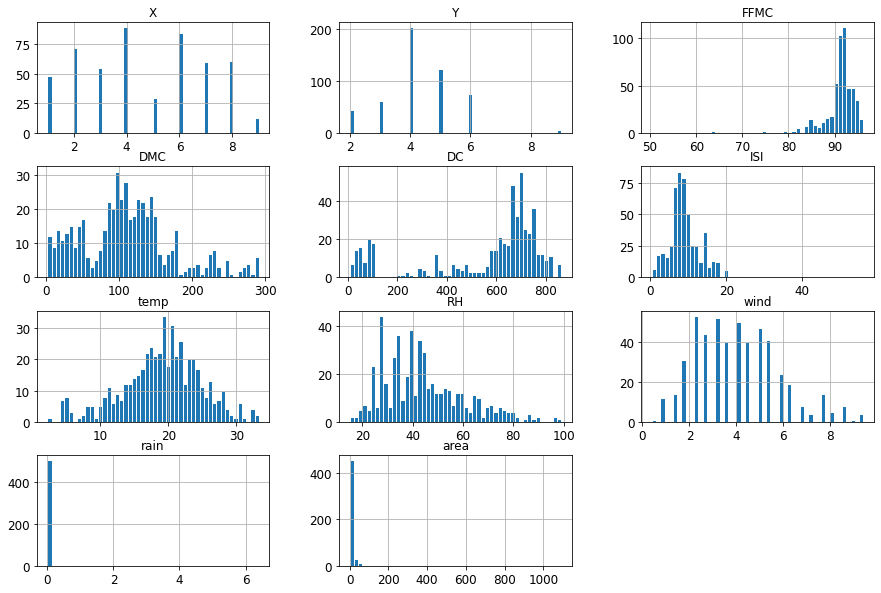

In [ ]:
#visualizing distributions 
forest_fire.hist(bins=50, figsize=(15,10), ec='w')
plt.show()
#target-area-is heavily skewed, we have extreme outliers.

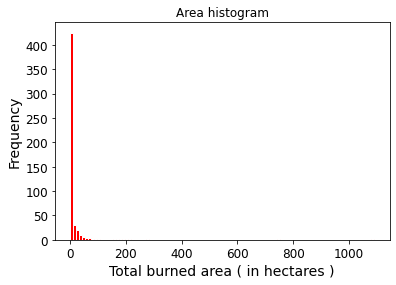

In [ ]:
plt.hist(forest_fire.area, ec='w', bins=100, color='red')
plt.title("Area histogram")
plt.xlabel("Total burned area ( in hectares )")
plt.ylabel("Frequency")
plt.show()
# plt.text(800,100, 'max: '+str(forest_fire.area.max()), color='black', fontsize=14)
#Burnt area attribute ranges from 0 to 1091.

In [ ]:
#Grouping the the burnt area to get a better understanding
forest_fire['area_cat'] = pd.cut(forest_fire['area'], bins=[0,5, 10, 50, 100, 1100], include_lowest=True, 
                                 labels=['0-5', '5-10', '10-50', '50-100', '>100'])
forest_fire.area_cat.value_counts()

0-5       362
10-50      70
5-10       56
50-100     13
>100       11
Name: area_cat, dtype: int64

In [ ]:
#Interquartile range
Q1 = forest_fire.area.quantile(.25)
Q3 = forest_fire.area.quantile(.75)
IQR = 1.5*(Q3-Q1)
IQR

9.85875

In [ ]:
#we are loosing quite a number of data points in already a small data set if we remove all outliers
forest_fire.query('(@Q1 - 1.5 * @IQR) <= area <= (@Q3 + 1.5 * @IQR)').area_cat.value_counts(sort=False)

0-5       362
5-10       56
10-50      37
50-100      0
>100        0
Name: area_cat, dtype: int64

In [ ]:
forest_fire.head()


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_cat
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0-5
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0-5
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0-5
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0-5
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0-5


In [ ]:
# I chose to remove any area greater than 100. 
#remove outliers
forest_fire.drop(forest_fire[forest_fire.area>100].index,axis=0, inplace=True)
forest_fire.area_cat.value_counts()

0-5       362
10-50      70
5-10       56
50-100     13
>100        0
Name: area_cat, dtype: int64

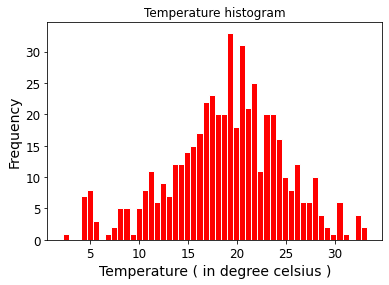

In [ ]:
# Assumption1- Temperature might be a great indicator of wildfires and it might be the case that high temperature may lead to more area burnt.¶
#Let's understand what temp ranges we have here.
plt.hist(forest_fire.temp, ec='w', bins=50, color='red')
plt.title("Temperature histogram")
plt.xlabel("Temperature ( in degree celsius )")
plt.ylabel("Frequency")
plt.show()

In [ ]:
forest_fire['temp_bins'] = pd.cut(forest_fire.temp, bins=[0, 15, 20, 25, 40], include_lowest=True, 
                                 labels=['0-15', '15-20', '20-25', '>25'])
forest_fire.temp_bins.value_counts(sort=False)
#so we have from very cold 0-15 degrees to hot >25 degree.

0-15     109
15-20    167
20-25    163
>25       62
Name: temp_bins, dtype: int64

In [ ]:
# As, I have assumed temp is a critical indicator, to have a golden test dataset I would prefer that both train and test has equally distributed temperature conditions. Stratified shuffle split will help us maintain the required strata compositions here.

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(forest_fire.values, forest_fire.temp_bins.values):
    st_train_set = forest_fire.iloc[train_index]
    st_test_set = forest_fire.iloc[test_index]

In [ ]:
#this works like magic.
print(st_test_set.temp_bins.value_counts(sort=False)/len(st_test_set), sep='\n')
print(forest_fire.temp_bins.value_counts(sort=False)/len(forest_fire), sep='\n')

0-15     0.217822
15-20    0.336634
20-25    0.326733
>25      0.118812
Name: temp_bins, dtype: float64
0-15     0.217565
15-20    0.333333
20-25    0.325349
>25      0.123752
Name: temp_bins, dtype: float64


In [ ]:
#now lets drop the area_cat and temp_bins 
for _ in (st_train_set, st_test_set):
    _.drop(['area_cat','temp_bins'], axis=1, inplace=True)

In [ ]:
st_train_set

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
359,1,4,sep,fri,92.5,122.0,789.7,10.2,21.1,39,2.2,0.0,8.12
314,4,4,sep,wed,92.6,115.4,777.1,8.8,19.7,41,1.8,0.0,1.58
203,8,6,oct,wed,91.4,37.9,673.8,5.2,20.2,37,2.7,0.0,13.70
319,5,4,sep,thu,92.8,119.0,783.5,7.5,21.6,28,6.3,0.0,4.41
51,4,3,aug,sun,90.2,99.6,631.2,6.3,21.5,34,2.2,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2,5,aug,fri,93.9,135.7,586.7,15.1,23.5,36,5.4,0.0,10.02
154,1,5,sep,sat,93.4,145.4,721.4,8.1,29.6,27,2.7,0.0,1.46
403,8,6,aug,thu,90.7,194.1,643.0,6.8,21.3,41,3.6,0.0,0.00
12,6,5,aug,fri,63.5,70.8,665.3,0.8,17.0,72,6.7,0.0,0.00


In [ ]:
st_test_set

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
505,1,2,aug,thu,91.0,163.2,744.4,10.1,26.7,35,1.8,0.0,5.80
432,8,6,aug,thu,94.8,222.4,698.6,13.9,23.9,38,6.7,0.0,0.00
217,1,3,sep,mon,88.6,91.8,709.9,7.1,12.4,73,6.3,0.0,30.32
416,6,3,jul,tue,92.7,164.1,575.8,8.9,26.3,39,3.1,0.0,7.02
100,3,4,aug,sun,91.4,142.4,601.4,10.6,19.8,39,5.4,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,3,4,aug,sun,91.4,142.4,601.4,10.6,19.8,39,5.4,0.0,0.00
366,4,5,sep,tue,91.1,132.3,812.1,12.5,15.9,38,5.4,0.0,1.75
433,2,4,aug,sun,93.6,235.1,723.1,10.1,20.9,66,4.9,0.0,15.34
435,2,5,jul,sat,90.8,84.7,376.6,5.6,23.8,51,1.8,0.0,0.00


**I chose to remove coordinates X & Y before model building. The reason being here we are building a model that will use weather conditions to determine the severity of a wildfire based on area burnt, so keeping X&Y locations of one forest does ‘t generalize well to others.**

In [ ]:
#create a fresh copy of train to preprocess
x_train = st_train_set.drop('area', axis=1)
y_train = st_train_set.area.copy()
categorical_attributes = list(x_train.select_dtypes(include=['object']).columns)
numerical_attributes = list(x_train.select_dtypes(include=['float64', 'int64']).columns)

# num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
#                          ('std_scaler', StandardScaler()),
#                         ])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant'))
                        ])
full_pipeline = ColumnTransformer([('num', num_pipeline, numerical_attributes),
                                   ('cat', OneHotEncoder(), categorical_attributes),
                                  ])
x_train = full_pipeline.fit_transform(x_train)
# #check the train data
x_train = pd.DataFrame(x_train, columns= numerical_attributes[0:] + list(full_pipeline.named_transformers_.cat.categories_[0]) +
             list(full_pipeline.named_transformers_.cat.categories_[1]))
x_train.pop("X");
x_train.pop("Y");
x_train.pop("apr");
x_train.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,aug,dec,feb,jul,jun,mar,oct,sep,fri,mon,sat,sun,thu,tue,wed
0,92.5,122.0,789.7,10.2,21.1,39.0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,92.6,115.4,777.1,8.8,19.7,41.0,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,91.4,37.9,673.8,5.2,20.2,37.0,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,92.8,119.0,783.5,7.5,21.6,28.0,6.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,90.2,99.6,631.2,6.3,21.5,34.0,2.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#create a fresh copy of test to preprocess
x_test = st_test_set.drop('area', axis=1)
y_test = st_test_set.area.copy()
categorical_attributes = list(x_test.select_dtypes(include=['object']).columns)
numerical_attributes = list(x_test.select_dtypes(include=['float64', 'int64']).columns)

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant'))
                        ])
full_pipeline = ColumnTransformer([('num', num_pipeline, numerical_attributes),
                                   ('cat', OneHotEncoder(), categorical_attributes),
                                  ])
x_test = full_pipeline.fit_transform(x_test)
# #check the test data
x_test = pd.DataFrame(x_test, columns= numerical_attributes[0:] + list(full_pipeline.named_transformers_.cat.categories_[0]) +
             list(full_pipeline.named_transformers_.cat.categories_[1]))
x_test.pop("X");
x_test.pop("Y");
x_test.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,aug,dec,feb,jul,jun,mar,oct,sep,fri,mon,sat,sun,thu,tue,wed
0,91.0,163.2,744.4,10.1,26.7,35.0,1.8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,94.8,222.4,698.6,13.9,23.9,38.0,6.7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,88.6,91.8,709.9,7.1,12.4,73.0,6.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,92.7,164.1,575.8,8.9,26.3,39.0,3.1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,91.4,142.4,601.4,10.6,19.8,39.0,5.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
forest_fire.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_cat,temp_bins
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0-5,0-15
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0-5,15-20
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0-5,0-15
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0-5,0-15
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0-5,0-15


Apply models


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(train, train_labels)

area_predictions = lin_reg.predict(train)
lin_mse = mean_squared_error(train_labels, area_predictions)
lin_rmse = np.sqrt(lin_mse)
print('linear_train_rmse', lin_rmse) #model might be underfitting

# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(lin_reg, train, train_labels, scoring='neg_mean_squared_error', cv=10)
# lin_rmse_scores = np.sqrt(-scores)

# def explain_scores(scores):
#     print("Scores:", scores)
#     print("Mean:", scores.mean())
#     print("Standard deviation:", scores.std())
 
# explain_scores(lin_rmse_scores)

linear_train_rmse 13.406066943162292


In [ ]:


tree_reg = DecisionTreeRegressor()
tree_reg.fit(train, train_labels)

area_predictions = tree_reg.predict(train)
tree_mse = mean_squared_error(train_labels, area_predictions)
tree_rmse = np.sqrt(tree_mse)
print('tree_train_rmse', tree_rmse) #model obviously overfitting

tree_train_rmse 3.741321429878308


In [ ]:


rf_reg = RandomForestRegressor()
rf_reg.fit(x_train, y_train)

area_predictions_reg = rf_reg.predict(x_test)
rf_mse = mean_squared_error(y_test, area_predictions_reg)
rf_rmse = np.sqrt(rf_mse)
print('rf_train_rmse', rf_rmse) #model is overfitting 

rf_train_rmse 14.911070877330566


In [ ]:
rec_reg=[]
for i in range(tol_max):
    rec_reg.append(rec(area_predictions_reg,y_test,i))

In [ ]:


svm_reg = SVR(kernel='linear')
svm_reg.fit(x_train, y_train)

area_predictions_svm = svm_reg.predict(x_test)
svm_mse = mean_squared_error(y_test, area_predictions_svm)
svm_rmse = np.sqrt(svm_mse)
print('svm_train_rmse', svm_rmse)

svm_train_rmse 14.69076461115119


In [ ]:
rec_SVR=[]
for i in range(tol_max):
    rec_SVR.append(rec(area_predictions_svm,y_test,i))

In [12]:
#and for final model I want to try GBM

xgb_reg = XGBRegressor()
xgb_reg.fit(x_train, y_train)

area_predictions_xgb = xgb_reg.predict(x_test)
xgb_mse = mean_squared_error(y_test, area_predictions_xgb)
xgb_rmse = np.sqrt(xgb_mse)
print('xgb_train_rmse', xgb_rmse) #overfitting

[15:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb_train_rmse 13.634200256448175


In [13]:
rec_XGB=[]
for i in range(tol_max):
    rec_XGB.append(rec(area_predictions_xgb,y_test,i))

# Gridsearch
Finding the right parameters for machine learning models is a tricky task! But luckily, Scikit-learn has the functionality of trying a bunch of combinations and see what works best, built in with GridSearchCV! The CV stands for cross-validation.

**GridSearchCV takes a dictionary that describes the parameters that should be tried and a model to train. The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.**

In [ ]:
#lets improve the models with hyperparameter tuning


param_grid = {'objective':['reg:linear'],
              'learning_rate': [0.02,0.03,0.04], 
              'max_depth': [1,2],
              'min_child_weight': [2,3,4],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.2,0.3,0.4],
              'n_estimators': [50,60,70,100]}

xgb_reg = XGBRegressor()

xgb_grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=4)
xgb_grid_search.fit(x_train,y_train)

xgb_negative_mse = xgb_grid_search.best_score_
xgb_rmse = np.sqrt(-xgb_negative_mse)
xgb_rmse

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 608 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:   20.1s finished


13.956079048764401

In [ ]:
xgb_grid_search.best_params_

{'colsample_bytree': 0.2,
 'learning_rate': 0.04,
 'max_depth': 1,
 'min_child_weight': 2,
 'n_estimators': 50,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.8}


**Regression Error Characteristic (REC) estimation**

Receiver Operating Characteristic (ROC) curves provide a powerful tool for visualizing and comparing classification results. Regression Error Characteristic (REC) curves generalize ROC curves to regression. REC curves plot the error tolerance on the $x-axis$ versus the percentage of points predicted within the tolerance on the $y-axis$. The resulting curve estimates the cumulative distribution function of the error. The REC curve visually presents commonly-useds tatistics. The area-over-the-curve (AOC) is a biased estimate of the expected error. The $R^2$ value can be estimated using the ratio of the AOC for a given model to the AOC for the nul-model. Users can quickly assess the relative merits of many regression functions by examining the relative position of their REC curves. The shape of the curve reveals additional information that can be used to guide modeling.

In [6]:

def rec(m,n,tol):
    if type(m)!='numpy.ndarray':
        m=np.array(m)
    if type(n)!='numpy.ndarray':
        n=np.array(n)
    l=m.size
    percent = 0
    for i in range(l):
        if np.abs(10**m[i]-10**n[i])<=tol:
            percent+=1
    return 100*(percent/l)

In [7]:
# Define the max tolerance limit for REC curve x-axis
# For this problem this represents the absolute value of error in the prediction of the outcome i.e. area burned
tol_max=20

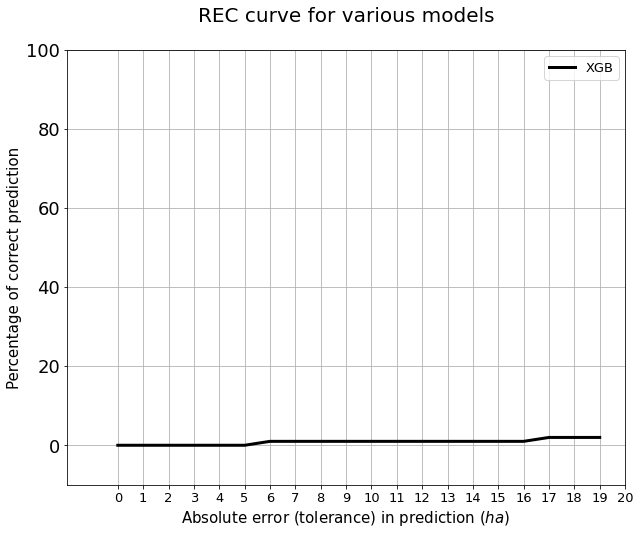

In [14]:


plt.figure(figsize=(10,8))
plt.title("REC curve for various models\n",fontsize=20)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)",fontsize=15)
plt.ylabel("Percentage of correct prediction",fontsize=15)
plt.xticks([i for i in range(0,tol_max+1,1)],fontsize=13)
plt.ylim(-10,100)
plt.xlim(-2,tol_max)
plt.yticks([i*20 for i in range(6)],fontsize=18)
plt.grid(True)
# plt.plot(range(tol_max),rec_XGB ,'--',lw=3)
plt.plot(range(tol_max),rec_XGB,'k-',lw=3)
plt.legend(['XGB'],fontsize=13)

NameError: ignored

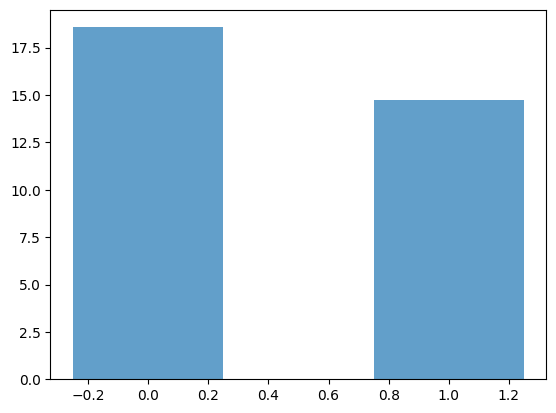

In [16]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('XGBoost', 'Genetic Algorithm')
y_pos = np.arange(len(objects))
performance = [18.57, 14.75]

plt.bar(y_pos, performance, align='center', alpha=0.7, width = 0.5,)
plt.xticks(y_pos, objects)
plt.ylabel('Learning models')
plt.ylabel('RMSE values')
plt.title('Model comparison')

plt.show()

# New Section

## **Libraries**

In [1]:
#support python 2&3
from __future__ import division, print_function, unicode_literals

#common imports
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from operator import add
import random
import logging
from tqdm import tqdm


# For pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#make notebook's output stable across runs
np.random.seed(42)


#Ignore useless warnings
import warnings
warnings.filterwarnings(action='ignore',message='^internal gelsd')
pd.options.mode.chained_assignment = None

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor


# Helper: Early stopping.
early_stopper = EarlyStopping(patience=5)

# **Preprocessing and NN model def**

In [2]:
def get_fire():

    # function to load data
    fire = pd.read_csv("forestfires.csv")
    fire.head()

    months_to_remove = ['nov','jan','may']
    forest_fire = fire.drop(fire[fire.month.isin(months_to_remove)].index ,axis=0)

    #Grouping the the burnt area to get a better understanding
    forest_fire['area_cat'] = pd.cut(forest_fire['area'], bins=[0,5, 10, 50, 100, 1100], include_lowest=True, 
                                  labels=['0-5', '5-10', '10-50', '50-100', '>100'])

    # I chose to remove any area greater than 100. 
    #remove outliers
    forest_fire.drop(forest_fire[forest_fire.area>100].index,axis=0, inplace=True)

    forest_fire['temp_bins'] = pd.cut(forest_fire.temp, bins=[0, 15, 20, 25, 40], include_lowest=True, 
                                  labels=['0-15', '15-20', '20-25', '>25'])

    # As, I have assumed temp is a critical indicator, to have a golden test dataset I would prefer that both train and test has equally distributed temperature conditions. Stratified shuffle split will help us maintain the required strata compositions here.
    # try StratifiedKFold(n_splits=1, test_size=0.2, random_state=42) 
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
    for train_index, test_index in split.split(forest_fire.values, forest_fire.temp_bins.values):
      st_train_set = forest_fire.iloc[train_index]
      st_test_set = forest_fire.iloc[test_index]

    #now lets drop the area_cat and temp_bins 
    for _ in (st_train_set, st_test_set):
      _.drop(['area_cat','temp_bins'], axis=1, inplace=True)

    #create a fresh copy of train to preprocess
    x_train = st_train_set.drop('area', axis=1)
    y_train = st_train_set.area.copy()
    categorical_attributes = list(x_train.select_dtypes(include=['object']).columns)
    numerical_attributes = list(x_train.select_dtypes(include=['float64', 'int64']).columns)

    num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('std_scaler', StandardScaler()),
                          ])
    full_pipeline = ColumnTransformer([('num', num_pipeline, numerical_attributes),
                                    ('cat', OneHotEncoder(), categorical_attributes),
                                    ])
    x_train = full_pipeline.fit_transform(x_train)
    # #check the train data
    x_train = pd.DataFrame(x_train, columns= numerical_attributes[0:] + list(full_pipeline.named_transformers_.cat.categories_[0]) +
              list(full_pipeline.named_transformers_.cat.categories_[1]))
    x_train.pop("X");
    x_train.pop("Y");
    x_train.pop("apr");



    #create a fresh copy of test to preprocess
    x_test = st_test_set.drop('area', axis=1)
    y_test = st_test_set.area.copy()
    categorical_attributes = list(x_test.select_dtypes(include=['object']).columns)
    numerical_attributes = list(x_test.select_dtypes(include=['float64', 'int64']).columns)

    num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('std_scaler', StandardScaler()),
                          ])
    full_pipeline = ColumnTransformer([('num', num_pipeline, numerical_attributes),
                                    ('cat', OneHotEncoder(), categorical_attributes),
                                    ])
    x_test = full_pipeline.fit_transform(x_test)
    # #check the test data
    x_test = pd.DataFrame(x_test, columns= numerical_attributes[0:] + list(full_pipeline.named_transformers_.cat.categories_[0]) +
              list(full_pipeline.named_transformers_.cat.categories_[1]))
    x_test.pop("X");
    x_test.pop("Y");

    return (x_train, y_train, x_test, y_test)



def compile_model(nb_neurons = 32, nb_layers = 1, activation = 'relu', optimizer = 'rmsprop'):

    model = Sequential()
    input_shape = (23,)
    # Add each layer.
    for i in range(nb_layers):

        # Need input shape for first layer.
        if i == 0:
            model.add(Dense(nb_neurons, activation=activation, input_shape=input_shape))
        else:
            model.add(Dense(nb_neurons, activation=activation))

        model.add(Dropout(0.2)) 

    # Output layer.
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

    return model



# **Get the data**

In [3]:
x_train, y_train, x_test, y_test = get_fire()


# **NN**

In [4]:
model = compile_model()
model.fit(x_train, y_train, batch_size = 10, epochs = 20, verbose = 0, callbacks = [early_stopper], validation_data=(x_test, y_test)) # using early stoping, so no real limit
y_pred= model.predict(x_test)
model_mse = mean_squared_error(y_test, y_pred)
model_rmse = np.sqrt(model_mse)
model_rmse

13.784375982394748

# **NN and grid search**

In [4]:
#lets improve the models with hyperparameter tuning

param_grid = {
        'nb_neurons': [8, 16, 32, 64, 128, 256, 512],
        'nb_layers': [1, 2, 3, 4, 5],
        'activation': ['relu', 'elu', 'tanh', 'linear'],
        'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      'adadelta', 'adamax'],
    }

nn = KerasRegressor(build_fn=compile_model, epochs=20, batch_size=10, verbose=0)

nn_grid_search = GridSearchCV(nn, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=5)
nn_grid_search.fit(x_train,y_train)

nn_negative_mse = nn_grid_search.best_score_
nn_rmse = np.sqrt(-nn_negative_mse)
nn_rmse

Fitting 5 folds for each of 840 candidates, totalling 4200 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   53.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  7.0min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 13.4min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 21.5min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 30.8min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 42.2min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 56.1min


KeyboardInterrupt: ignored

# **NN and random search**

In [5]:
#lets improve the models with hyperparameter tuning

param_grid = {
        'nb_neurons': [8, 16, 32, 64, 128, 256, 512],
        'nb_layers': [1, 2, 3, 4, 5],
        'activation': ['relu', 'elu', 'tanh', 'linear'],
        'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      'adadelta', 'adamax'],
    }

# nn = compile_model(input_shape)

# xgb_reg = XGBRegressor()
nn = KerasRegressor(build_fn=compile_model, epochs=20, batch_size=10, verbose=0)

nn_grid_search = RandomizedSearchCV(nn, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=5)
nn_grid_search.fit(x_train,y_train)

nn_negative_mse = nn_grid_search.best_score_
nn_rmse = np.sqrt(-nn_negative_mse)
nn_rmse

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  1.6min finished


14.102416970251172

# **XGBoost and grid search**

In [10]:
#lets improve the models with hyperparameter tuning


param_grid = {'objective':['reg:linear'],
              'learning_rate': [0.02,0.03,0.04], 
              'max_depth': [1,2],
              'min_child_weight': [2,3,4],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.2,0.3,0.4],
              'n_estimators': [50,60,70,100]}

xgb_reg_grid = XGBRegressor()

xgb_grid_search = GridSearchCV(xgb_reg_grid, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=4)
xgb_grid_search.fit(x_train,y_train)

xgb_negative_mse = xgb_grid_search.best_score_
xgb_rmse_grid = np.sqrt(-xgb_negative_mse)
xgb_rmse_grid

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 348 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 848 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:   22.6s finished


13.956079048764401

# **XGBoost and random search**

In [11]:
#lets improve the models with hyperparameter tuning


param_rand = {'objective':['reg:linear'],
              'learning_rate': [0.02,0.03,0.04], 
              'max_depth': [1,2],
              'min_child_weight': [2,3,4],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.2,0.3,0.4],
              'n_estimators': [50,60,70,100]}

xgb_reg_rand = XGBRegressor()

xgb_rand_search = RandomizedSearchCV(xgb_reg_rand, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=4)
xgb_rand_search.fit(x_train,y_train)

xgb_negative_mse = xgb_rand_search.best_score_
xgb_rmse_rnd = np.sqrt(-xgb_negative_mse)
xgb_rmse_rnd

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.1s finished


14.009516792981753

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [24]:
print('R-squared: {}'.format(r2_score(y_test, y_pred)))

R-squared: -0.146048062706861


In [6]:
model = compile_model()
model.fit(x_train, y_train, batch_size = 10, epochs = 20, verbose = 0, callbacks = [early_stopper], validation_data=(x_test, y_test)) # using early stoping, so no real limit
y_pred= model.predict(x_test)
model_mse = mean_squared_error(y_test, y_pred)
model_rmse = np.sqrt(model_mse)
model_rmse

13.715440584875005

In [8]:
rec_nn=[]
for i in range(tol_max):
    rec_nn.append(rec(y_pred, y_test,i))

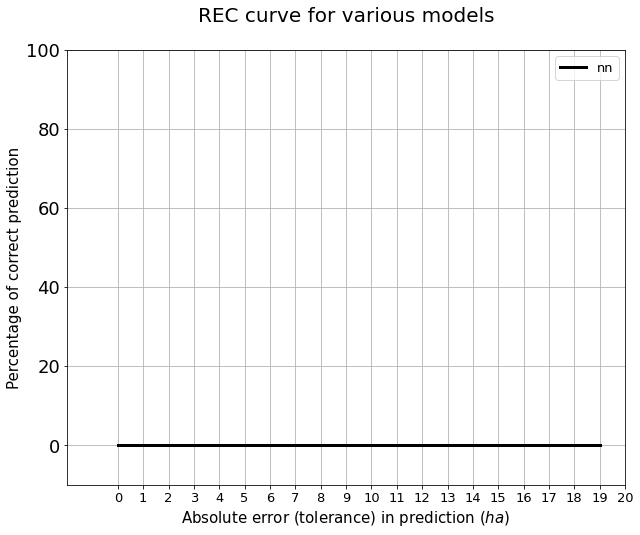

In [9]:
plt.figure(figsize=(10,8))
plt.title("REC curve for various models\n",fontsize=20)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)",fontsize=15)
plt.ylabel("Percentage of correct prediction",fontsize=15)
plt.xticks([i for i in range(0,tol_max+1,1)],fontsize=13)
plt.ylim(-10,100)
plt.xlim(-2,tol_max)
plt.yticks([i*20 for i in range(6)],fontsize=18)
plt.grid(True)
# plt.plot(range(tol_max),rec_XGB ,'--',lw=3)
plt.plot(range(tol_max),rec_nn,'k-',lw=3)
plt.legend(['nn'],fontsize=13)

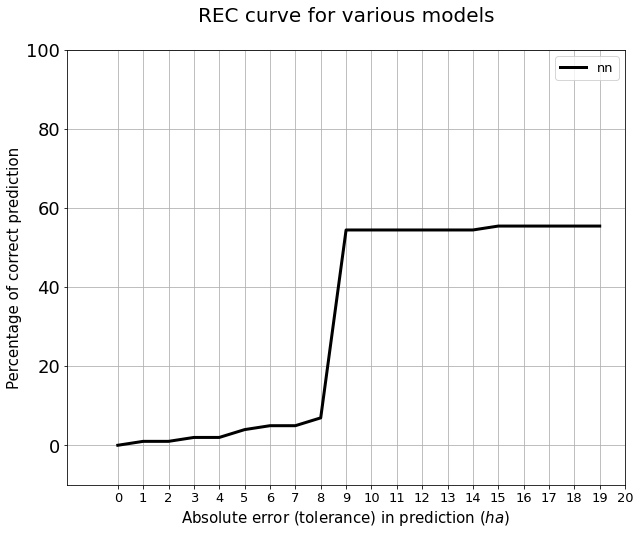

In [12]:
plt.figure(figsize=(10,8))
plt.title("REC curve for various models\n",fontsize=20)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)",fontsize=15)
plt.ylabel("Percentage of correct prediction",fontsize=15)
plt.xticks([i for i in range(0,tol_max+1,1)],fontsize=13)
plt.ylim(-10,100)
plt.xlim(-2,tol_max)
plt.yticks([i*20 for i in range(6)],fontsize=18)
plt.grid(True)
# plt.plot(range(tol_max),rec_XGB ,'--',lw=3)
plt.plot(range(tol_max),rec_nn,'k-',lw=3)
plt.legend(['nn'],fontsize=13)